In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorflow as tf

In [2]:
class DeepNeuralNetworks:
    def __init__(self, X, y, layers, num_nodes, weights_init, activation):
        self.layers = layers # int => includes sum of all hidden layers and output layer
        self.num_nodes = num_nodes # list
        self.weights_init = weights_init # string
        self.input_size = X.shape[0] # assuming X.shape: (n, m)
        self.input_instance = X.shape[1]
        self.activation = activation
        self.X = X
        self.y = y

    def weights_initialization(self):
        weights = {}
        num_nodesx = [self.input_size] + self.num_nodes
        for layer in range(1, self.layers+1):
            weights['w_'+str(layer)] = np.random.randn(num_nodesx[layer], num_nodesx[layer-1]) # shape => n[l]xn[l-1]
            if self.weights_init.lower() == "random":
                weights['w_'+str(layer)] *= 0.01
            elif self.weights_init.lower() == "he":
                weights['w_'+str(layer)] *= np.sqrt(2/num_nodesx[layer-1])
            elif self.weights_init.lower() == "xavier" or self.weights_init.lower() == "glorot":
                weights['w_'+str(layer)] *= np.sqrt(2/(num_nodesx[layer-1] + num_nodesx[layer]))
            else:
                pass
            weights['b_'+str(layer)] = np.zeros((num_nodesx[layer], 1)) # shape => n[l]x1
        return weights

    def activation_function(self, activation, z):
        if activation.lower() == "sigmoid":
            z = np.clip(z, -500, 500)
            return 1/np.add(1, np.exp(-z))
        elif activation.lower() == "relu":
            return np.maximum(0, z)
        elif activation.lower() == "tanh":
            return np.tanh(z)
        elif activation.lower() == "leaky_relu":
            return np.maximum(0.01*z, z)

    def forward_propagation(self, X, weights):
        layer_values = {}
        layer_values['a_0'] = X
        for layer in range(1, self.layers+1):
            layer_values['z_'+str(layer)] = np.add(np.dot(weights['w_'+str(layer)], layer_values['a_'+str(layer-1)]), weights['b_'+str(layer)])
            if layer < self.layers: # relu for all hidden layers and sigmoid for output layer
                layer_values['a_'+str(layer)] = self.activation_function(self.activation, layer_values['z_'+str(layer)])
            else:
                layer_values['a_'+str(layer)] = self.activation_function("sigmoid", layer_values['z_'+str(layer)])
        return layer_values

    def loss_calculation(self, y, a):
        epsilon = 1e-8
        y = y.reshape(a.shape)
        a_new = np.clip(a, a_min=epsilon, a_max=1-epsilon)
        return -np.mean(np.add(np.multiply(y, np.log(a_new)), np.multiply((1-y), np.log(1-a_new)))) # Binary Cross-entropy

    def activation_derivation(self, activation, z):
        if activation.lower() == "sigmoid":
            sig = self.activation_function("sigmoid", z)
            return np.multiply(sig, 1-sig)
        elif activation.lower() == "leaky_relu":
            dz = np.zeros_like(z)
            dz[z>=0] = 1
            dz[z<0] = 0.01
            return dz
        elif activation.lower() == "tanh":
            return 1 - np.power(np.tanh(z), 2)
        else: # here for other cases and relu
            dz = np.zeros_like(z)
            dz[z>=0] = 1
            return dz

    def back_propagation(self, y, layer_values, weights):
        parameters = {}
        epsilon = 1e-8
        y = y.reshape(1, -1)
        m = y.shape[1]
        for layer in range(self.layers, 0, -1):
            if layer == self.layers:
                parameters['dz_'+str(layer)] = layer_values['a_'+str(layer)] - y
                a_new = np.clip(layer_values['a_'+str(layer)], a_min=epsilon, a_max=1-epsilon)
                parameters['da_'+str(layer)] = - (y/a_new) + ((1-y)/(1-a_new))
            else:
                parameters['da_'+str(layer)] = np.dot(weights['w_'+str(layer+1)].T, parameters['dz_'+str(layer+1)])
                parameters['dz_'+str(layer)] = np.multiply(parameters['da_'+str(layer)], self.activation_derivation(self.activation, layer_values['z_'+str(layer)]))
            parameters['dw_'+str(layer)] = 1/m * np.dot(parameters['dz_'+str(layer)], layer_values['a_'+str(layer-1)].T)
            parameters['db_'+str(layer)] = 1/m * np.sum(parameters['dz_'+str(layer)], axis=1, keepdims=True)        
        return parameters

    def optimizer_initialize(self, optimizer, parameters):
        grad_names = list(filter(lambda x: (x.startswith("dw") == True) or (x.startswith("db") == True), parameters.keys()))
        if optimizer.lower() == "momentum":
            for name in grad_names:
                parameters['V'+name] = np.zeros(parameters[name].shape)
        elif optimizer.lower() == "rmsprop":
            for name in grad_names:
                parameters['S'+name] = np.zeros(parameters[name].shape)
        elif optimizer.lower() == "adam":
            for name in grad_names:
                parameters['V'+name] = np.zeros(parameters[name].shape)
                parameters['S'+name] = np.zeros(parameters[name].shape)
        else:
            pass
        return parameters

    def optimization(self, optimizer, parameters, beta1, beta2):
        if optimizer.lower() == "momentum":
            grad_names = list(filter(lambda x: x.startswith("V") == True, parameters.keys()))
            for name in grad_names:
                parameters[name] = np.multiply(beta1, parameters[name]) + np.multiply((1 - beta1), parameters[name[1:]])
        elif optimizer.lower() == "rmsprop":
            grad_names = list(filter(lambda x: x.startswith("S") == True, parameters.keys()))
            for name in grad_names:
                parameters[name] = np.multiply(beta2, parameters[name]) + np.multiply((1 - beta2), np.square(parameters[name[1:]]))
        elif optimizer.lower() == "adam":
            v_grad_names = list(filter(lambda x: x.startswith("V"), parameters.keys()))
            s_grad_names = list(filter(lambda x: x.startswith("S"), parameters.keys()))
            for v_name, s_name in zip(v_grad_names, s_grad_names):
                grad_name = v_name[1:]
                parameters[v_name] = np.multiply(beta1, parameters[v_name]) + np.multiply((1 - beta1), parameters[grad_name])
                parameters[s_name] = np.multiply(beta2, parameters[s_name]) + np.multiply((1 - beta2), np.square(parameters[grad_name]))
        else:
            pass
        return parameters

    def weights_updation(self, parameters, weights, learning_rate, optimizer="normal", t=1, beta1=0.9, beta2=0.999, epsilon=10e-8):
        for layer in range(1, self.layers+1):
            if optimizer.lower() == "momentum":
                weights['w_'+str(layer)] -= learning_rate*parameters['Vdw_'+str(layer)]
                weights['b_'+str(layer)] -= learning_rate*parameters['Vdb_'+str(layer)]
            elif optimizer.lower() == "rmsprop":
                sdwc = np.clip(parameters['Sdw_'+str(layer)], a_min=0, a_max=None)
                sdbc = np.clip(parameters['Sdb_'+str(layer)], a_min=0, a_max=None)
                weights['w_'+str(layer)] -= learning_rate*(np.divide(parameters['dw_'+str(layer)], (np.sqrt(sdwc) + epsilon)))
                weights['b_'+str(layer)] -= learning_rate*(np.divide(parameters['db_'+str(layer)], (np.sqrt(sdbc) + epsilon)))
            elif optimizer.lower() == "adam":
                parameters['Vdwc_'+str(layer)] = parameters['Vdw_'+str(layer)]/(1 - np.power(beta1, t))
                parameters['Vdbc_'+str(layer)] = parameters['Vdb_'+str(layer)]/(1 - np.power(beta1, t))
                parameters['Sdwc_'+str(layer)] = parameters['Sdw_'+str(layer)]/(1 - np.power(beta2, t))
                parameters['Sdbc_'+str(layer)] = parameters['Sdb_'+str(layer)]/(1 - np.power(beta2, t))
                sdwc = np.clip(parameters['Sdwc_'+str(layer)], a_min=0, a_max=None)
                sdbc = np.clip(parameters['Sdbc_'+str(layer)], a_min=0, a_max=None)
                weights['w_'+str(layer)] -= learning_rate*(parameters['Vdwc_'+str(layer)] / (np.sqrt(parameters['Sdwc_'+str(layer)]) + epsilon))
                weights['b_'+str(layer)] -= learning_rate*(parameters['Vdbc_'+str(layer)] / (np.sqrt(parameters['Sdbc_'+str(layer)]) + epsilon))
            else:
                weights['w_'+str(layer)] -= learning_rate*parameters['dw_'+str(layer)]
                weights['b_'+str(layer)] -= learning_rate*parameters['db_'+str(layer)]
        return weights

    def train_model(self, X, Y, gd, num_iterations, batch_size=32, learning_rate=0.001, optimizer="normal", beta1=0.9, beta2=0.999, epsilon=10e-8): # X.shape => (n x m), y.shape => (n x 1)
        Y = Y.reshape(1, -1)
        weights = self.weights_initialization()
        losses = []
        
        if gd == "mini-batch":
            for i in range(num_iterations):
                if i%50 == 0:
                    print(f"iteration: {i}: [=======]")
                elif i%20 == 0:
                    print(f"{i}...")
                ls = []

                num_batches = int(np.ceil(X.shape[1]/batch_size))
                
                batch = 0
                start = 0
                end = 0+batch_size
                x = X[:, start: end].reshape(X.shape[0], -1)
                y = Y[0, start: end].reshape(1, -1)
                layer_activations = self.forward_propagation(x, weights)
                loss = self.loss_calculation(y, layer_activations['a_'+str(self.layers)])
                gradients = self.back_propagation(y, layer_activations, weights)
                ls.append(loss)

                if optimizer.lower() == "momentum":
                    gradients = self.optimizer_initialize(optimizer, gradients)
                    gradients = self.optimization(optimizer, gradients, beta1, beta2)
                    weights = self.weights_updation(parameters=gradients, weights=weights, learning_rate=learning_rate, optimizer=optimizer, t=1, beta1=beta1, beta2=beta2, epsilon=epsilon)
                elif optimizer.lower() == "rmsprop":
                    gradients = self.optimizer_initialize(optimizer, gradients)
                    gradients = self.optimization(optimizer, gradients, beta1, beta2)
                    weights = self.weights_updation(parameters=gradients, weights=weights, learning_rate=learning_rate, optimizer=optimizer, t=1, beta1=beta1, beta2=beta2, epsilon=epsilon)
                elif optimizer.lower() == "adam":
                    gradients = self.optimizer_initialize(optimizer, gradients)
                    gradients = self.optimization(optimizer, gradients, beta1, beta2)
                    weights = self.weights_updation(parameters=gradients, weights=weights, learning_rate=learning_rate, optimizer=optimizer, t=1, beta1=beta1, beta2=beta2, epsilon=epsilon)
                else:
                    weights = self.weights_updation(gradients, weights, learning_rate)

                for batch in range(1, num_batches):
                    start = batch*batch_size
                    end = start + batch_size
                    x = X[:, start: end].reshape(X.shape[0], -1)
                    y = Y[0, start: end].reshape(1, -1)
                    layer_activations = self.forward_propagation(x, weights)
                    loss = self.loss_calculation(y, layer_activations['a_'+str(self.layers)])
                    gradients = self.back_propagation(y, layer_activations, weights)
                    gradients = self.optimizer_initialize(optimizer, gradients)
                    gradients = self.optimization(optimizer, gradients, beta1, beta2)
                    weights = self.weights_updation(parameters=gradients, weights=weights, learning_rate=learning_rate, optimizer=optimizer, t=batch, beta1=beta1, beta2=beta2, epsilon=epsilon)
                    ls.append(loss)
                losses.append(np.mean(ls))
                
            self.weights = weights
            self.losses = losses
            print("...training done")
            
        elif gd == "stochastic":
            for i in range(num_iterations):
                if i%50 == 0:
                    print(f"iteration: {i}: [=", end="")
                elif i%20 == 0:
                    print(f"{i}...")
                ls = []

                x = X[:, 0].reshape(-1, 1)
                y = Y[0][0].reshape(1, 1)
                layer_activations = self.forward_propagation(x, weights)
                loss = self.loss_calculation(y, layer_activations['a_'+str(self.layers)])
                gradients = self.back_propagation(y, layer_activations, weights)
                ls.append(loss)

                if optimizer.lower() == "momentum":
                    gradients = self.optimizer_initialize(optimizer, gradients)
                    gradients = self.optimization(optimizer, gradients, beta1, beta2)
                    weights = self.weights_updation(parameters=gradients, weights=weights, learning_rate=learning_rate, optimizer=optimizer, t=1, beta1=beta1, beta2=beta2, epsilon=epsilon)
                elif optimizer.lower() == "rmsprop":
                    gradients = self.optimizer_initialize(optimizer, gradients)
                    gradients = self.optimization(optimizer, gradients, beta1, beta2)
                    weights = self.weights_updation(parameters=gradients, weights=weights, learning_rate=learning_rate, optimizer=optimizer, t=1, beta1=beta1, beta2=beta2, epsilon=epsilon)
                elif optimizer.lower() == "adam":
                    gradients = self.optimizer_initialize(optimizer, gradients)
                    gradients = self.optimization(optimizer, gradients, beta1, beta2)
                    weights = self.weights_updation(parameters=gradients, weights=weights, learning_rate=learning_rate, optimizer=optimizer, t=1, beta1=beta1, beta2=beta2, epsilon=epsilon)
                else:
                    weights = self.weights_updation(gradients, weights, learning_rate)
                
                for j in range(1, X.shape[1]):
                    x = X[:, j].reshape(-1, 1)
                    y = Y[0][j].reshape(1, 1)
                    layer_activations = self.forward_propagation(x, weights)
                    loss = self.loss_calculation(y, layer_activations['a_'+str(self.layers)])
                    gradients = self.back_propagation(y, layer_activations, weights)
                    gradients = self.optimizer_initialize(optimizer, gradients)
                    gradients = self.optimization(optimizer, gradients, beta1, beta2)
                    weights = self.weights_updation(parameters=gradients, weights=weights, learning_rate=learning_rate, optimizer=optimizer, t=j, beta1=beta1, beta2=beta2, epsilon=epsilon)
                    ls.append(loss)
                    if (j%50 == 0) & (i%50 == 0):
                        print("=", end="")
                    if (j == X.shape[1]-1) & (i%50 == 0):
                        print("=] 100%")
                losses.append(np.mean(ls))

            self.weights = weights
            self.losses = losses
            print("...training done")
                    
        else:
            for i in range(0, num_iterations):
                layer_activations = self.forward_propagation(X, weights)
                loss = self.loss_calculation(Y, layer_activations['a_'+str(self.layers)])
                gradients = self.back_propagation(Y, layer_activations, weights)
                weights = self.weights_updation(gradients, weights, learning_rate)
                losses.append(loss)

            self.weights = weights
            self.losses = losses
            print("...training done")

    def check_loss(self):
        print(f"Maximum loss value: {self.losses[0]}")
        print(f"Minimum loss value: {self.losses[-1]}")
        plt.plot(self.losses)
        plt.xlabel("#Iterations")
        plt.ylabel("Loss")
        plt.title("Loss v/s num_iterations")
        plt.show()

    def predict(self, X_test):
        weights = self.weights
        layer_activations = self.forward_propagation(X_test, weights)
        return np.round(layer_activations['a_'+str(self.layers)])

In [10]:
%%time

X = np.random.rand(12, 2000)
X_test = np.random.rand(12, 100)

Y = np.random.randint(2, size=(2000))

nn = DeepNeuralNetworks(X=X, y=Y, layers=5, num_nodes=[10, 7, 5, 8, 1], weights_init="he", activation="tanh")
nn.train_model(X=X, Y=Y, gd="mini-batch", num_iterations=100, learning_rate=0.01, optimizer="momentum")
preds = nn.predict(X_test)

preds, preds.shape

iteration: 0: [=======]
20...
40...
iteration: 50: [=======]
60...
80...
...training done
CPU times: total: 1.8 s
Wall time: 2.53 s


(array([[0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
         0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
         0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
         1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 1., 1.]]),
 (1, 100))

Maximum loss value: 0.7076381119560011
Minimum loss value: 0.6939282881004321


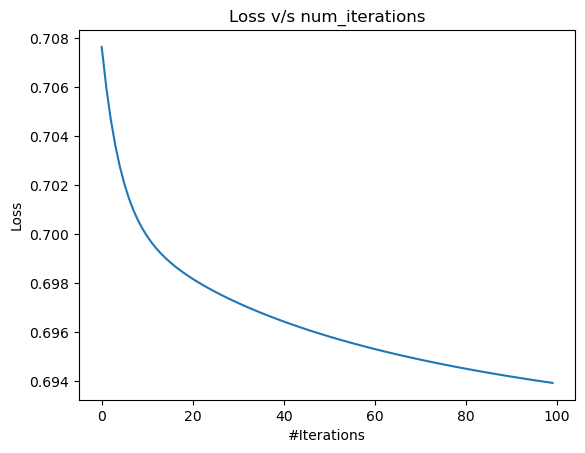

In [8]:
nn.check_loss()

In [6]:
Out[3]

(array([[1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
         1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
         1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.,
         0., 1., 0., 1.]]),
 (1, 100))

In [11]:
Out[10]

(array([[0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
         0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
         0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
         0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
         1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
         0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 1., 1.]]),
 (1, 100))

In [5]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, value_and_grad